# 1. Project Setup

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow tensorflow-gpu tensorflow-io matplotlib

## 1.2 Load Dependencies

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

# 2. Data Loading

## 2.1 Define Paths to Files

In [2]:
CAPUCHIN_FILE = os.path.join('data', 'positives', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'negatives', 'afternoon-birds-song-in-forest-0.wav')

## 2.2 Build Dataloading Function

In [2]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [ ]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

In [ ]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Dataset

## 3.1 Define Paths

In [3]:
POS = os.path.join('data', 'positives')
NEG = os.path.join('data', 'negatives')

## 3.2 Tensorflow Datasets

In [4]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

2022-05-09 11:12:02.762442: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 11:12:02.843282: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 11:12:02.843538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-09 11:12:02.845372: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## 3.3 Label and Combine Samples

In [5]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [6]:
pos.as_numpy_iterator().next()

b'data/Parsed_Capuchinbird_Clips/XC526106-4.wav'

In [7]:
positives.as_numpy_iterator().next()

(b'data/Parsed_Capuchinbird_Clips/XC388470-6.wav', 1.0)

# 4. Determine Average Length

## 4.1 Calculate Wave Cycle Length

In [ ]:
lengths = []
for file in os.listdir(os.path.join('data', 'positives')):
    tensor_wave = load_wav_16k_mono(os.path.join('data', 'positives', file))
    lengths.append(len(tensor_wave))

In [ ]:
lengths

## 4.2 Calculate Mean, Min and Max

In [ ]:
tf.math.reduce_mean(lengths)

In [ ]:
tf.math.reduce_min(lengths)

In [ ]:
tf.math.reduce_max(lengths)

# 5. Data Preprocessing

## 5.1 Preprocessing Function

In [8]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Function

In [ ]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [ ]:
spectrogram, label = preprocess(filepath, label)

In [ ]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Split Training & Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [9]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

2022-05-09 11:12:40.438545: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


## 6.2 70/30 Split

In [10]:
train = data.take(36)
test = data.skip(36).take(15)

## 6.3 Test

In [ ]:
samples, labels = train.as_numpy_iterator().next()

In [ ]:
labels

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [12]:
model = Sequential()
model.add(Conv2D(8, (3,3), activation='relu', input_shape=(1491,257,1)))
model.add(Conv2D(8, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [13]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 8)      80        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 8)      584       
                                                                 
 flatten (Flatten)           (None, 3009688)           0         
                                                                 
 dense (Dense)               (None, 32)                96310048  
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 96,310,745
Trainable params: 96,310,745
Non-trainable params: 0
_________________________________________________________________


## 7.3 Fit Model, View Loss and KPI Plots

In [15]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4


2022-05-09 11:13:23.081211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 352 of 1000
2022-05-09 11:13:33.109499: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 624 of 1000
2022-05-09 11:13:39.811001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-05-09 11:13:41.572996: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303


36/36 [==============================] - 38s 190ms/step - loss: 1.1402 - recall: 0.9342 - precision: 0.9045 - val_loss: 0.0629 - val_recall: 0.9841 - val_precision: 0.9394
Epoch 2/4
36/36 [==============================] - 7s 183ms/step - loss: 0.0985 - recall: 0.9744 - precision: 0.9268 - val_loss: 0.0370 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/4
36/36 [==============================] - 7s 188ms/step - loss: 0.0208 - recall: 0.9933 - precision: 1.0000 - val_loss: 0.0092 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/4
36/36 [==============================] - 7s 184ms/step - loss: 0.0040 - recall: 1.0000 - precision: 1.0000 - val_loss: 6.7060e-04 - val_recall: 1.0000 - val_precision: 1.0000


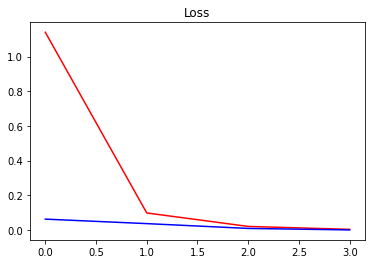

In [16]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

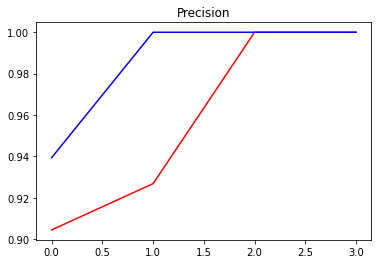

In [17]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

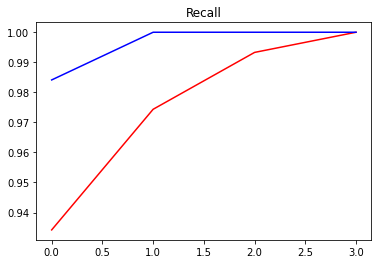

In [18]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [19]:
X_test, y_test = test.as_numpy_iterator().next()

In [21]:
# 16 spectrograms
X_test.shape

(16, 1491, 257, 1)

In [22]:
# with 16 labels
y_test.shape

(16,)

In [20]:
yhat = model.predict(X_test)

In [24]:
# Everything close to 1.00000000e+00 is a positive
yhat

array([[9.99920249e-01],
       [3.07901189e-08],
       [1.00000000e+00],
       [2.84484369e-25],
       [9.62874225e-09],
       [9.99707282e-01],
       [1.53503152e-05],
       [2.34340667e-03],
       [8.77155067e-28],
       [1.00000000e+00],
       [1.14530545e-08],
       [5.61734714e-06],
       [3.27430301e-20],
       [1.99461836e-11],
       [0.00000000e+00],
       [0.00000000e+00]], dtype=float32)

## 8.2 Convert Logits to Classes 

In [21]:
# Make it binary
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [22]:
yhat

[1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]

In [23]:
# How many positives in prediction?
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=6>

In [24]:
# How many positives were actually there?
tf.math.reduce_sum(y_test)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [25]:
# Make sure that we don't have false positives
yhat

[1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1]

In [26]:
y_test.astype(int)

array([1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1])

# 9. Build RAW Data Parsing Functions

## 9.1 Load up MP3s

In [27]:
def load_mp3_16k_mono(filename):
    # Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. 
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [28]:
mp3 = os.path.join('data', 'raw', 'recording_00.mp3')

In [29]:
wav = load_mp3_16k_mono(mp3)

In [30]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [32]:
len(audio_slices)

60

In [33]:
samples, index = audio_slices.as_numpy_iterator().next()

In [35]:
samples.shape

(1, 48000)

## 9.2 Data Preprocessing

In [37]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Make Predictions

In [42]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [49]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.9 else 0 for prediction in yhat]

In [54]:
yhat

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

In [51]:
tf.math.reduce_sum(yhat)

<tf.Tensor: shape=(), dtype=int32, numpy=8>

## 9.4 Group Consecutive Detections

In [48]:
from itertools import groupby

In [52]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [53]:
calls

5

# 10. Make Predictions

## 10.1 Loop over all recordings and make predictions

In [55]:
results = {}
for file in os.listdir(os.path.join('data', 'raw')):
    FILEPATH = os.path.join('data','raw', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [56]:
results

{'recording_00.mp3': array([[1.7967954e-05],
        [2.2968070e-08],
        [2.5104802e-07],
        [9.9962211e-01],
        [1.0000000e+00],
        [1.7161149e-09],
        [4.8879667e-07],
        [9.4560582e-09],
        [2.4789443e-08],
        [2.5388106e-05],
        [8.4285728e-07],
        [2.3511647e-07],
        [3.2778482e-07],
        [1.0000000e+00],
        [1.0000000e+00],
        [3.2529167e-07],
        [8.1133295e-14],
        [1.3599146e-07],
        [3.7930611e-05],
        [3.7935457e-05],
        [2.4059464e-06],
        [3.1183745e-07],
        [2.9855541e-05],
        [7.3505151e-01],
        [1.0000000e+00],
        [1.9188672e-08],
        [4.6475018e-10],
        [1.5136159e-06],
        [1.1760284e-09],
        [1.4105116e-06],
        [3.4862407e-07],
        [4.3302392e-05],
        [1.9442025e-06],
        [1.0053354e-05],
        [3.7805878e-06],
        [7.5453153e-07],
        [1.0000000e+00],
        [3.6084123e-07],
        [1.7232368e-08],
     

## 10.2 Convert Predictions into Classes

In [57]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

## 10.3 Group Consecutive Detections

In [58]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 0,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_17.mp3': 3,
 'recording_18.mp3': 5,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 16,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 16,
 'recording_29.mp3': 0,
 'recording_30.mp3': 2,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 9,
 'recording_40.mp3': 1,
 'recording_41.mp3': 0,
 'recording_42.mp3': 0,
 'recording_4

# 11. Export Results

In [59]:
import csv

In [60]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'detections'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])